Réseau inspiré de http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

(tiré du TP du cours CNN de Mr Bailly)

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

# Import the functions from fgsm.py
from fgsm_copie import adv_attack, test

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # convertit les images [H,W,C] dont les valeurs sont dans [0,255] en tenseurs [C,H,W] dont les valeurs sont dans [0,1]
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [4]:
# Set the hyperparameters
input_dim = 784
num_classes = 10
num_centers = 100
num_epochs = 10
batch_size = 100
learning_rate = 1e-3

epsilon = 0.3
device = torch.device('cpu')

In [8]:

# There we create the class for our Shallow RBF network

class ShallowRBF(nn.Module):
    def __init__(self, input_dim, num_classes, num_centers):
        super(ShallowRBF, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers))
        self.fc = nn.Linear(num_centers, num_classes)

    def forward(self, x):
        
        x = x.view(x.size(0), -1)  # Flatten the input
        # Calculate the RBF activations
        rbf_activations = torch.exp(-self.beta * torch.norm(x.unsqueeze(1) - self.centers, dim=2))

        # Normalize the RBF activations
        rbf_activations = rbf_activations / torch.sum(rbf_activations, dim=1, keepdim=True)

        # Pass the normalized RBF activations through the linear layer
        output = self.fc(rbf_activations)

        return output


# Initialize the model
model1 = ShallowRBF(input_dim, num_classes, num_centers)


architecture de réseau inspirée de ce repository : https://github.com/insujeon/rbfn/blob/master/RBFN_MNIST.ipynb

In [5]:
class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.centers = centers
        self.num_centers = centers.size(0)
        self.num_class = num_class
    
        self.linear = torch.nn.Linear(self.num_centers, self.num_class, bias=True)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)

    def radial_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        C = torch.exp(-self.beta.mul((A-B).pow(2).sum(2,keepdim=False).sqrt() ) )
        return C
    
    def forward(self, batches):
        radial_val = self.radial_fun(batches)
        class_score = self.linear(radial_val)
        return class_score


batch_images, batch_labels = next(iter(train_loader))

centers = batch_images
#centers = torch.rand(1000,28*28)

#model2 = RbfNet(Variable(centers.cuda()), num_class=10)
model2 = RbfNet(centers, num_class=10)
 
#model2.cuda()

In [6]:
criterion = nn.CrossEntropyLoss()
sgd = optim.SGD(model2.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

In [7]:
# Boucle d'entraînement
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        sgd.zero_grad()
        output = model2(data)
        loss = criterion(output, target)
        loss.backward()
        sgd.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332397
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.285809
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.285624
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.308640
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.266896
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.276988
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.282711
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.283157
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.252144
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.249834
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.277305
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.273928
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.222377
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.150349
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.028753
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.993090
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.053288
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.079282
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.943239
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.874995
Train Epoch:

In [9]:
b_size = 5
data = test_loader.dataset.data[0:b_size].data.unsqueeze(1).float()
target = test_loader.dataset.targets[0:b_size]
pred = model2(data)
print(pred.argmax(dim=1, keepdim=False))
print(target)

tensor([0, 0, 0, 0, 0])
tensor([7, 2, 1, 0, 4])


In [10]:
test_loss = 0
correct = 0
# pour ne pas calculer les gradients (gain de temps et de mémoire)
with torch.no_grad():
    for data, target in test_loader:
        output = model2(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0189, Accuracy: 5919/10000 (59.2%)



## Test du RBF network avec adversarial attack (type fgsm)

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [9]:
accuracies = []
examples = []
confidences = []

# Run test for each epsilon
for eps in epsilons:
    accuracy, example, confidence = test(model2, device, test_loader, eps)
    accuracies.append(accuracy)
    examples.append(example)
    confidences.append(confidence)

Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de labels : torch.Size([64])
Taille de final_pred : torch.Size([64, 1])
Taille de

In [11]:
print(accuracies)
print(confidences)

[5.681528662420382, 5.681528662420382, 5.681528662420382, 5.681528662420382, 5.681528662420382, 5.681528662420382, 5.681528662420382]
[tensor([0.1651, 0.1576, 0.1607, 0.1583, 0.1533, 0.1559, 0.1554, 0.1511, 0.1536,
        0.1428, 0.1629, 0.1510, 0.1557, 0.1582, 0.1549, 0.1511],
       grad_fn=<MaxBackward0>), tensor([0.1676, 0.1609, 0.1641, 0.1620, 0.1519, 0.1580, 0.1553, 0.1529, 0.1567,
        0.1447, 0.1652, 0.1544, 0.1593, 0.1618, 0.1536, 0.1532],
       grad_fn=<MaxBackward0>), tensor([0.1695, 0.1637, 0.1670, 0.1651, 0.1507, 0.1600, 0.1553, 0.1543, 0.1595,
        0.1464, 0.1669, 0.1575, 0.1626, 0.1649, 0.1525, 0.1552],
       grad_fn=<MaxBackward0>), tensor([0.1708, 0.1660, 0.1693, 0.1675, 0.1496, 0.1616, 0.1552, 0.1554, 0.1619,
        0.1479, 0.1680, 0.1603, 0.1655, 0.1673, 0.1513, 0.1568],
       grad_fn=<MaxBackward0>), tensor([0.1713, 0.1675, 0.1708, 0.1691, 0.1484, 0.1627, 0.1549, 0.1559, 0.1637,
        0.1491, 0.1685, 0.1625, 0.1677, 0.1689, 0.1501, 0.1580],
       grad_

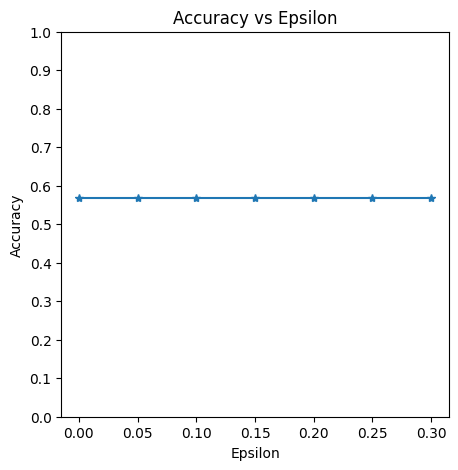

In [23]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, [accuracy/10 for accuracy in accuracies], "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


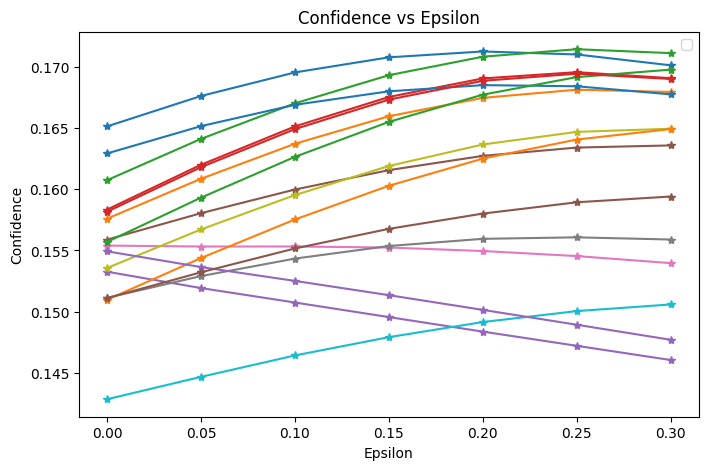

In [22]:
plt.figure(figsize=(8,5))
plt.plot(epsilons, [confidence.detach().numpy() for confidence in confidences], "*-")
plt.title("Confidence vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Confidence")
plt.legend()
plt.show()
